<a href="https://colab.research.google.com/github/teddyclark/ml4va-traffic-stop/blob/main/ML4VA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**ML4VA Project**
CS4774

Teddy Clark (ejc7re)
Srikar Kosuri (sk8nr)
Alex Snow (ats5cn)

In [ ]:
from pandas.plotting import scatter_matrix # optional
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
import os

np.random.seed(42)

# The dataset is pretty massive and takes like 10 minutes to upload to the runtime
# (accessible in the shared drive folder)
# Maybe we get most recent million rows? Or 500K? Currently there are 5M
def load_data():
    csv_path = os.path.join(".", "VA-edited.csv")
    return pd.read_csv(csv_path)

In [ ]:
stops = load_data()
print(stops.info())
print(stops.describe())
print(np.shape(stops))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223978 entries, 0 to 223977
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   stop_date         223978 non-null  object
 1   county_name       223978 non-null  object
 2   county_fips       223978 non-null  int64 
 3   driver_race_raw   216173 non-null  object
 4   driver_race       216173 non-null  object
 5   search_conducted  223978 non-null  bool  
 6   contraband_found  217432 non-null  object
 7   officer_id        223978 non-null  int64 
 8   officer_race      223972 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 13.9+ MB
None
         county_fips     officer_id
count  223978.000000  223978.000000
mean    51184.710570    7116.599086
std       225.374649    1290.248463
min     51001.000000    1617.000000
25%     51059.000000    6455.000000
50%     51107.000000    7465.000000
75%     51173.000000    8141.000000
max     51840.000000

In [ ]:
stops = stops.dropna(how='any', axis=0)

Drop rows with NULL data. Since our data is primarily categorical, it doesn't make sense to use a method to estimate their value, so we simply neglect that row.

In [ ]:
stops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209659 entries, 0 to 223977
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   stop_date         209659 non-null  object
 1   county_name       209659 non-null  object
 2   county_fips       209659 non-null  int64 
 3   driver_race_raw   209659 non-null  object
 4   driver_race       209659 non-null  object
 5   search_conducted  209659 non-null  bool  
 6   contraband_found  209659 non-null  object
 7   officer_id        209659 non-null  int64 
 8   officer_race      209659 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 14.6+ MB


In [ ]:
stops['stop_date'] = stops['stop_date'].str.split('/').str[0]
stops['stop_date'].value_counts

<bound method IndexOpsMixin.value_counts of 0         4
1         4
2         4
3         4
4         4
         ..
223973    7
223974    7
223975    7
223976    7
223977    7
Name: stop_date, Length: 209659, dtype: object>

A lot of columns for a dataset contains minimal data for rows, suggesting that a lot of data remains to be collected or was simply neglected. We could remove these columns?

stop_time, fine_grained_location, police_department, driver_gender, driver_age, etc. are some of them.

We still do have officer_race and driver_race, and if there was a search conducted. so we could potentially focus on that. We have date as well as county so we could do it with respect to time/location

In [ ]:
from sklearn.model_selection import train_test_split

stops = stops[stops['county_name'] != "Charlottesville city"]
stops['minority'] = stops['driver_race'].apply(lambda x: 'Colored' if x!='White' else 'White')  
X = stops[["stop_date", "county_name", "officer_race"]]
y = stops[["minority"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = stops["county_name"])

print(np.shape(X_train))
print(np.shape(X_test))

print(X_train)
print(X_test)

(167726, 3)
(41932, 3)
       stop_date           county_name officer_race
175903        11       Stafford County        White
11023          3      Dinwiddie County        White
75066          8  Prince Edward County        White
185550        10    Mecklenburg County        White
45356         11      Charlotte County        White
...          ...                   ...          ...
78363          8      Botetourt County        White
113092         5        Pulaski County        White
99418          6        Fairfax County     Hispanic
74498          8       Accomack County        White
48171         11       New Kent County        White

[167726 rows x 3 columns]
       stop_date            county_name officer_race
116642         5    Chesterfield County        White
9220           3         Loudoun County        White
4730           4          Louisa County        White
63664          9    Westmoreland County        White
137514         3           Bland County        White
...     

Reformatting data for future use with log regressiona and nns

In [ ]:
from sklearn.compose import ColumnTransformer

categorical_pipeline = Pipeline([
    ('one_hot', OneHotEncoder()),
])

print(np.shape(X_train))
print(np.shape(X_test))
X_train_prepared = categorical_pipeline.fit_transform(X_train)
X_test_prepared = categorical_pipeline.fit_transform(X_test)

(167726, 3)
(41932, 3)


In [ ]:
print(np.shape(X_train_prepared))
print(np.shape(X_test_prepared))
print(np.shape(y_train))
print(np.shape(y_test))

(167726, 142)
(41932, 138)
(167726, 1)
(41932, 1)


The following is code used to reformat the data and run a k-means algorithm. The k-means uses the three categories "county_name," "driver_race," and "officer_race," to see if there are any noteable patterns between counties and the races of the officers/offenders.

In [ ]:
names = list(X['county_name'].value_counts(sort=True, ascending=False)[0:4].index)
names.append('Albemarle County')

In [ ]:
print(names)

['Fairfax County', 'Prince William County', 'Arlington County', 'Henrico County', 'Albemarle County']


In [ ]:
X_cluster = X[X['county_name'].apply(lambda x: x in names)].drop("stop_date", axis = 1)
X_cluster['driver_race'] = stops['driver_race'][X['county_name'].apply(lambda x: x in names)]
column_names = list(X_cluster['county_name'].unique())
column_names.extend([name + ' officer' for name in list(X_cluster['officer_race'].unique())])
column_names.extend([name + ' driver' for name in list(X_cluster['driver_race'].unique())])
X_cluster_prepped = categorical_pipeline.fit_transform(X_cluster)
X_cluster_prepped.shape

(44062, 15)

In [ ]:
X_cluster.columns

Index(['county_name', 'officer_race', 'driver_race'], dtype='object')

The following is used to see if there is an optimal number of clusters for the k-means algo, by plotting the elbow curve for 2-12 clusters

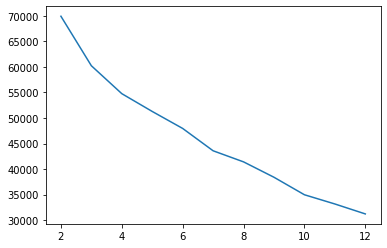

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# Number of clusters
inertia_list = []
for i in range(2,13):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, random_state=42).fit(X_cluster_prepped)
  inertia_list.append(kmeans.inertia_)

plt.plot([i for i in range(2,13)], inertia_list)

7 clusters seems to have a slight elbow, so we use if for our implementation

In [ ]:
kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=100, random_state=42).fit(X_cluster_prepped)

In [ ]:
interpret_df
centroids = kmeans.cluster_centers_
interpret_df = pd.DataFrame(centroids, columns=column_names)

In [ ]:
interpret_df

,Prince William County,Fairfax County,Albemarle County,Henrico County,Arlington County,Hispanic officer,White officer,Black officer,Asian officer,Other officer,White driver,Black driver,Asian driver,Hispanic driver,Other driver
0,0.000000,0.000000,1.000000,0.000000,0.000000,0.033321,0.000000,0.075489,0.016378,0.874812,0.192959,0.362011,0.289345,0.155685,0.000000
1,0.116283,0.000000,0.000000,0.883717,0.000000,0.000000,0.069736,0.101496,0.001680,0.827088,0.044530,0.294068,0.078642,0.057805,0.524954
2,0.001777,0.179650,0.215936,0.082642,0.519994,0.000000,0.998963,0.000148,0.000889,0.000000,0.105598,0.480746,0.162618,0.096712,0.154325
3,0.000000,0.000000,0.000000,0.000000,1.000000,0.078345,0.000000,0.074910,0.005725,0.841021,0.098953,0.296860,0.203467,0.061335,0.339385
4,0.000613,0.111134,0.888253,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.161593,0.000000,0.235751,0.148110,0.454545
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.027433,0.000000,0.068147,0.016547,0.887873,0.000000,0.000000,0.000000,0.000000,1.000000
6,0.159751,0.840249,0.000000,0.000000,0.000000,0.017339,0.000000,0.062147,0.001753,0.918761,0.134814,0.311709,0.196961,0.100526,0.255991


We then reformat the y values to be used in our nueral network implementation down the road.

In [ ]:
y_train_prepared, y_test_prepared = (np.where(y_set == 'Colored', 1, 0) for y_set in (y_train, y_test))

There is a size mismatch after running OneHot for the classification models. Going to try a different method for managing categorical data

In [ ]:
train_objs_num = len(X_train)
data = pd.concat(objs=[X_train, X_test], axis=0)
data = pd.get_dummies(data)

X_train_prepared = np.copy(data[:train_objs_num])
X_test_prepared = np.copy(data[train_objs_num:])

In [ ]:
print(np.shape(X_train_prepared))
print(np.shape(X_test_prepared))
print(np.shape(y_train))
print(np.shape(y_test))

(167726, 142)
(41932, 142)
(167726, 1)
(41932, 1)


We first fit the data to logistic regression to see if we can reasonably predict the race of the driver from the county, stop month, and officer's race

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log_model_2 = LogisticRegression(solver = 'lbfgs')
clf = GridSearchCV(log_model_2, param_grid = hyperparameters, cv = 5, verbose=True, n_jobs=-1)
best_model = clf.fit(X_train_prepared, y_train_prepared)
preds = best_model.predict(X_test_prepared)
accuracy_score(y_test_prepared, preds)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown i

0.6080082037584661

We achieved a non-random prediction accuracy of 60.8% with the best parameters. We now build a deep network to see if we can improve our predictions at all.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
nn_model = keras.models.Sequential([keras.layers.Dense(426,input_dim = 142, activation = 'relu'),
                                    keras.layers.Dense(852, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')
                                    ])

In [ ]:
nn_model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

nn_model.fit(X_train_prepared, y_train_prepared, validation_split=.2, epochs = 20)

nn_model.evaluate(x = X_test_prepared, y = y_test_prepared)

Epoch 1/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6630 - accuracy: 0.6016 - val_loss: 0.6586 - val_accuracy: 0.6067
Epoch 2/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6599 - accuracy: 0.6065 - val_loss: 0.6608 - val_accuracy: 0.6071
Epoch 3/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6590 - accuracy: 0.6086 - val_loss: 0.6584 - val_accuracy: 0.6086
Epoch 4/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6586 - accuracy: 0.6094 - val_loss: 0.6594 - val_accuracy: 0.6096
Epoch 5/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6581 - accuracy: 0.6090 - val_loss: 0.6589 - val_accuracy: 0.6084
Epoch 6/20
4194/4194 [==============================] - 25s 6ms/step - loss: 0.6577 - accuracy: 0.6109 - val_loss: 0.6592 - val_accuracy: 0.6092
Epoch 7/20
4194/4194 [==============================] - 24s 6ms/step - loss: 0.6574 - accuracy: 0.6101 - val_loss: 0.6603 - val_ac

[0.6614605188369751, 0.6027616262435913]

We achieve 60.2% with this network, less than the logistic regression. We then move add one more dense layer and see if the model improves at all.

In [ ]:
nn_model_2 = keras.models.Sequential([keras.layers.Dense(426,input_dim = 142, activation = 'relu'),
                                    keras.layers.Dense(852, activation='relu'),
                                    keras.layers.Dense(1704, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')
                                    ])

In [ ]:
nn_model_2.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

nn_model_2.fit(X_train_prepared, y_train_prepared, validation_split=.3, epochs = 20)

nn_model_2.evaluate(x = X_test_prepared, y = y_test_prepared)

Epoch 1/20
3669/3669 [==============================] - 83s 23ms/step - loss: 0.6639 - accuracy: 0.6020 - val_loss: 0.6610 - val_accuracy: 0.6038
Epoch 2/20
3669/3669 [==============================] - 84s 23ms/step - loss: 0.6601 - accuracy: 0.6066 - val_loss: 0.6612 - val_accuracy: 0.6048
Epoch 3/20
3669/3669 [==============================] - 84s 23ms/step - loss: 0.6591 - accuracy: 0.6076 - val_loss: 0.6609 - val_accuracy: 0.6052
Epoch 4/20
3669/3669 [==============================] - 83s 23ms/step - loss: 0.6584 - accuracy: 0.6089 - val_loss: 0.6597 - val_accuracy: 0.6069
Epoch 5/20
3669/3669 [==============================] - 85s 23ms/step - loss: 0.6578 - accuracy: 0.6097 - val_loss: 0.6604 - val_accuracy: 0.6067
Epoch 6/20
3669/3669 [==============================] - 84s 23ms/step - loss: 0.6575 - accuracy: 0.6109 - val_loss: 0.6606 - val_accuracy: 0.6061
Epoch 7/20
3669/3669 [==============================] - 84s 23ms/step - loss: 0.6568 - accuracy: 0.6107 - val_loss: 0.6623 -

[0.663589596748352, 0.6002814173698425]

The new model has performed slightly worse than the previous one, with accuracy of about 60.0%

In [ ]:
y_no_stop = X_cluster['driver_race'].apply(lambda x: 'Colored' if x!='White' else 'White') 
X_no_stop = X_cluster.drop('driver_race', axis=1)

X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_no_stop, y_no_stop, test_size=0.2, random_state=42, stratify = X_no_stop["county_name"])

X_train_ns_prepared = categorical_pipeline.fit_transform(X_train_ns)
X_test_ns_prepared = categorical_pipeline.fit_transform(X_test_ns)

y_train_ns_prepared, y_test_ns_prepared = (np.where(y_set == 'Colored', 1, 0).reshape(y_set.shape[0]) for y_set in (y_train_ns, y_test_ns))

In [ ]:
np.asarray(X_train_ns_prepared)

numpy.ndarray

We run a new model on the data with only the top 4 counties + albemarle, and without using the stop date as a feature.

In [ ]:
nn_model_ns = keras.models.Sequential([keras.layers.Dense(30,input_dim = 10, activation = 'relu'),
                                    keras.layers.Dense(90, activation='relu'),
                                    keras.layers.Dense(270, activation='relu'),
                                    keras.layers.Dense(90, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')
                                    ])

sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6)

nn_model_ns.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

nn_model_ns.fit(X_train_ns_prepared, y_train_ns_prepared, epochs = 20)

nn_model_ns.evaluate(x = X_test_ns_prepared, y = y_test_ns_prepared)

Epoch 1/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6295 - accuracy: 0.6724
Epoch 2/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6287 - accuracy: 0.6727
Epoch 3/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6283 - accuracy: 0.6727
Epoch 4/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6278 - accuracy: 0.6727
Epoch 5/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6276 - accuracy: 0.6727
Epoch 6/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6277 - accuracy: 0.6727
Epoch 7/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6277 - accuracy: 0.6727
Epoch 8/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6277 - accuracy: 0.6727
Epoch 9/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.6275 - accuracy: 0.6727
Epoch 10/20
1102/1102 [==============================] - 3s 2ms/step - loss: 0.627

[0.6243352890014648, 0.6780892014503479]

We achieve 67.8% accuracy with the new model.